## Explore the dataset and extract the data needed to train the model.




---


### import important libraries

In [2]:
%%capture
!pip install mediapipe

In [4]:
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

### loading & exploring the dataset

In [5]:
# Loading AFLW2000 Data

drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
folder_path = '/content/drive/MyDrive/AFLW2000/'

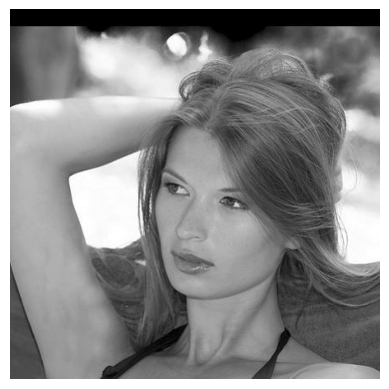

In [7]:
random_file = 'image00797'

image = cv2.imread(folder_path +random_file+'.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(image)

### extract the facial landmarks using mediapipe

face_mesh extract 468 face landmarks, based on this photo. Nose index = 1, so nose point position can be easily extracted for later normlization and centralize the axises.

nose position:  (0.4719025194644928, 0.6018232107162476)
number of points: 468
distance x: 0.04508817195892334
distance y: 0.18845075368881226
(450, 450, 3)


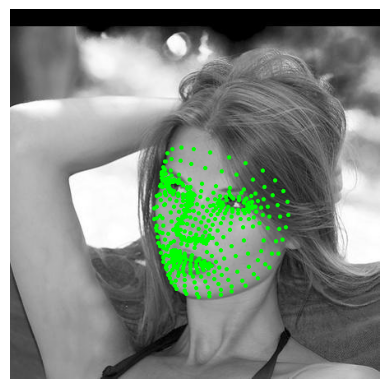

In [8]:
X = []
Y = []

faceModule = mediapipe.solutions.face_mesh

# loading image and its correspinding mat file
image = cv2.imread(folder_path +random_file+'.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
with faceModule.FaceMesh(static_image_mode=True) as faces:

    # processing the face to extract the landmark points for x,y
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:

      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y

              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])

              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
              X.append(relative_x)
              Y.append(relative_y)
          for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
              if idx ==4:
                nose_x = lm.x
                nose_y = lm.y

              if idx == 0:
                lower_x = lm.x
                lower_y = lm.y

              if idx == 9:
                upper_x = lm.x
                upper_y = lm.y

distance_x = abs(upper_x - lower_x)
distance_y = abs(upper_y - lower_y)

print('nose position: ', (nose_x, nose_y))
print('number of points:', len(X))
print('distance x:', distance_x)
print('distance y:', distance_y)

print(image.shape)
plt.axis('off')
plt.imshow(image)

### extract image labels (yaw - pitch - roll) and draw the axises


In [10]:
def draw_axes(img, pitch,yaw,roll, center_point, size = 100):

    yaw = -yaw

    if center_point is None:
        height, width = img.shape[:2]
        center_point = (width / 2, height / 2)

    tdx, tdy = center_point

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

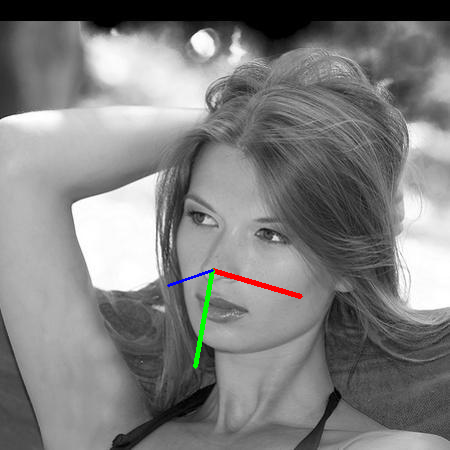

In [11]:
image = cv2.imread(folder_path +random_file+'.jpg')

# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat(folder_path +random_file+'.mat')

# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]

h, w, c = image.shape
center_point = (nose_x * w, nose_y * h)

cv2_imshow(draw_axes(image, pitch, yaw, roll, center_point))

each image has 468 point and each point has x-axis and y-axis, so the dataset should consist of:

*   2000 observations (images)
*   936 features (468 x-points, 468 y-points)
*   3 labels





### Extract the dataset (normalized)

In [ ]:
# Create lists to store data
all_data = []

faceModule = mediapipe.solutions.face_mesh

# Loop through all image files in the folder
for image_file in os.listdir(folder_path):
    if image_file.endswith('.jpg'):
        # Load the image
        image_path = os.path.join(folder_path, image_file)
        image = cv2.imread(image_path)

        # Process the face to extract landmark points
        with faceModule.FaceMesh(static_image_mode=True) as faces:
            results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            data = []

            if results.multi_face_landmarks is not None:

              #extract nose point for points refrence (centralization), and axis drawing
              #extract 2 other points for shaping the face size within the same range
              for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
                if idx == 4:
                  nose_x = lm.x
                  nose_y = lm.y

                if idx == 291:
                  lower_x = lm.x
                  lower_y = lm.y

                if idx == 33:
                  upper_x = lm.x
                  upper_y = lm.y

              distance_x = upper_x - lower_x
              distance_y = upper_y - lower_y
              distance = np.sqrt(distance_x**2 + distance_y**2)

              #filling the list with extracted facial landmarks
              for face in results.multi_face_landmarks:
                  for landmark in face.landmark:
                      x = (landmark.x - nose_x) / distance
                      y = (landmark.y - nose_y) / distance
                      shape = image.shape
                      X = int(x * shape[1])
                      Y = int(y * shape[0])
                      data.extend([X, Y])

             #fill with 'null' if no points detected
            else:
                data = ['null'] * 936

            # Load the corresponding mat file to extract pitch, yaw, roll
            mat_file_path = os.path.join(folder_path, image_file.replace('.jpg', '.mat'))
            mat_file = sio.loadmat(mat_file_path)
            pose_para = mat_file["Pose_Para"][0][:3]
            pitch = pose_para[0]
            yaw = pose_para[1]
            roll = pose_para[2]

            data.extend([pitch, yaw, roll])
            all_data.append(data)

# Create a dataframe
cols = []
for num in range(0, 468):
  for dim in ('x_', 'y_'):
    cols.append(f'{dim}{num}')
cols.extend(['pitch', 'yaw', 'roll'])

df = pd.DataFrame(all_data, columns=cols)

In [ ]:
df

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,...,y_464,x_465,y_465,x_466,y_466,x_467,y_467,pitch,yaw,roll
0,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,-0.075096,-1.115535,0.202319
1,-121,139,-12,37,-109,70,-61,-86,0,0,...,-197,-90,-186,-42,-228,-37,-253,-1.108159,-1.443685,1.129171
2,52,100,7,24,43,35,-8,-75,0,0,...,-182,92,-169,275,-223,292,-244,-0.373085,0.293578,-0.125011
3,0,79,0,23,0,29,-24,-77,0,0,...,-189,46,-176,212,-244,223,-254,-0.474087,-0.040907,0.019801
4,-37,94,-4,29,-23,48,-26,-76,0,0,...,-147,26,-141,165,-161,177,-164,-0.116700,-0.233745,0.095809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-77,129,-9,31,-66,56,-45,-79,0,0,...,-182,-38,-171,48,-224,55,-238,-0.266459,-0.722653,0.219750
1996,7,105,-1,29,7,48,-11,-77,0,0,...,-158,81,-151,261,-180,275,-190,-0.161717,0.085792,0.027202
1997,52,114,2,30,43,59,6,-65,0,0,...,-134,119,-129,300,-158,322,-168,-0.046365,0.580349,-0.023616
1998,-6,134,2,27,-12,70,-38,-50,0,0,...,-114,0,-109,115,-144,125,-164,-0.948136,-1.241852,1.234426


In [ ]:
df = df[df['x_0'] != 'null']

In [ ]:
df.shape

(1853, 939)

In [ ]:
# Save dataframe to CSV

df.to_csv('/content/face_landmarks.csv', index=False)

## The whole dataset was used to train a model to detect the labels needed, test the model using test images to evaluate the model performance

---



###loading the dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/face_landmarks.csv')
df

,x_0,y_0,x_1,y_1,x_2,y_2,x_3,y_3,x_4,y_4,...,y_464,x_465,y_465,x_466,y_466,x_467,y_467,pitch,yaw,roll
0,-121,139,-12,37,-109,70,-61,-86,0,0,...,-197,-90,-186,-42,-228,-37,-253,-1.108159,-1.443685,1.129171
1,52,100,7,24,43,35,-8,-75,0,0,...,-182,92,-169,275,-223,292,-244,-0.373085,0.293578,-0.125011
2,0,79,0,23,0,29,-24,-77,0,0,...,-189,46,-176,212,-244,223,-254,-0.474087,-0.040907,0.019801
3,-37,94,-4,29,-23,48,-26,-76,0,0,...,-147,26,-141,165,-161,177,-164,-0.116700,-0.233745,0.095809
4,-94,139,-8,35,-98,70,-70,-77,0,0,...,-190,-118,-178,-87,-232,-85,-247,-0.379067,-0.985426,0.086955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1848,-77,129,-9,31,-66,56,-45,-79,0,0,...,-182,-38,-171,48,-224,55,-238,-0.266459,-0.722653,0.219750
1849,7,105,-1,29,7,48,-11,-77,0,0,...,-158,81,-151,261,-180,275,-190,-0.161717,0.085792,0.027202
1850,52,114,2,30,43,59,6,-65,0,0,...,-134,119,-129,300,-158,322,-168,-0.046365,0.580349,-0.023616
1851,-6,134,2,27,-12,70,-38,-50,0,0,...,-114,0,-109,115,-144,125,-164,-0.948136,-1.241852,1.234426


### Features-labels split and train-validation-test split

In [ ]:
labels = df[['pitch', 'yaw', 'roll']]
Pitch = df[['pitch']]
Yaw = df[['yaw']]
Roll = df[['roll']]
features = df.drop(['pitch', 'yaw', 'roll'], axis=1)

## Random state hyperparameter selection were used as the main parameter to be repeatedly changed for finding the best algorithm and score for model training.
note: multi Output Regressor were used to find the best optimized model without making 3 medels at the beginning for code simplicity.

used algorithms:
- Linear Regression.
- Ridge Regression.
- Lasso Regression.
- Support Vector Regression.
- K-Nearest Neighbors Regression.
- Huber Regression.

In [ ]:
max_score = -1
best_random_state = None

for rm in range(1, 500):

    # Split the data
    x_train, x_validation_test, y_train, y_validation_test = train_test_split(features, labels, test_size=0.4, random_state=rm)
    x_train, x_validation_test, pitch_train, pitch_validation_test = train_test_split(features, Pitch, test_size=0.4, random_state=rm)
    x_train, x_validation_test, yaw_train, yaw_validation_test = train_test_split(features, Yaw, test_size=0.4, random_state=rm)
    x_train, x_validation_test, roll_train, roll_validation_test = train_test_split(features, Roll, test_size=0.4, random_state=rm)
    x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, pitch_validation, pitch_test = train_test_split(x_validation_test, pitch_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, yaw_validation, yaw_test = train_test_split(x_validation_test, yaw_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, roll_validation, roll_test = train_test_split(x_validation_test, roll_validation_test, test_size=0.5, random_state=rm)

    # Train the MultiOutputRegressor Linear regression model
    lreg = MultiOutputRegressor(LinearRegression()).fit(x_train, y_train)

    # Get the score on the validation set
    current_score = lreg.score(x_validation, y_validation)

    # Check if the current score is the maximum so far
    if current_score > max_score:
        max_score = current_score
        best_random_state = rm

# Print the maximum score and the corresponding random state
print(f"Maximum Linear Regression Score: {max_score} (Random State: {best_random_state})")

Maximum Linear Regression Score: 0.2579754533726087 (Random State: 456)


In [ ]:
max_score = -1
best_random_state = None

for rm in range(1, 500):

    # Split the data
    x_train, x_validation_test, y_train, y_validation_test = train_test_split(features, labels, test_size=0.4, random_state=rm)
    x_train, x_validation_test, pitch_train, pitch_validation_test = train_test_split(features, Pitch, test_size=0.4, random_state=rm)
    x_train, x_validation_test, yaw_train, yaw_validation_test = train_test_split(features, Yaw, test_size=0.4, random_state=rm)
    x_train, x_validation_test, roll_train, roll_validation_test = train_test_split(features, Roll, test_size=0.4, random_state=rm)
    x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, pitch_validation, pitch_test = train_test_split(x_validation_test, pitch_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, yaw_validation, yaw_test = train_test_split(x_validation_test, yaw_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, roll_validation, roll_test = train_test_split(x_validation_test, roll_validation_test, test_size=0.5, random_state=rm)

    # Train the MultiOutputRegressor Ridge regression model
    rid = MultiOutputRegressor(Ridge()).fit(x_train, y_train)

    # Get the score on the validation set
    current_score = rid.score(x_validation, y_validation)

    # Check if the current score is the maximum so far
    if current_score > max_score:
        max_score = current_score
        best_random_state = rm

# Print the maximum score and the corresponding random state
print(f"Maximum Ridge Regression Score: {max_score} (Random State: {best_random_state})")

Maximum Ridge Regression Score: 0.44488814840632634 (Random State: 307)


In [ ]:
max_score = -1
best_random_state = None

for rm in range(1, 500):

    # Split the data
    x_train, x_validation_test, y_train, y_validation_test = train_test_split(features, labels, test_size=0.4, random_state=rm)
    x_train, x_validation_test, pitch_train, pitch_validation_test = train_test_split(features, Pitch, test_size=0.4, random_state=rm)
    x_train, x_validation_test, yaw_train, yaw_validation_test = train_test_split(features, Yaw, test_size=0.4, random_state=rm)
    x_train, x_validation_test, roll_train, roll_validation_test = train_test_split(features, Roll, test_size=0.4, random_state=rm)
    x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, pitch_validation, pitch_test = train_test_split(x_validation_test, pitch_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, yaw_validation, yaw_test = train_test_split(x_validation_test, yaw_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, roll_validation, roll_test = train_test_split(x_validation_test, roll_validation_test, test_size=0.5, random_state=rm)

    # Train the MultiOutputRegressor Lasso regression model
    lasso = MultiOutputRegressor(linear_model.Lasso()).fit(x_train, y_train)

    # Get the score on the validation set
    current_score = lasso.score(x_validation, y_validation)

    # Check if the current score is the maximum so far
    if current_score > max_score:
        max_score = current_score
        best_random_state = rm

# Print the maximum score and the corresponding random state
print(f"Maximum Lasso Regression Score: {max_score} (Random State: {best_random_state})")

Maximum Lasso Regression Score: 0.8705041438802796 (Random State: 307)


In [ ]:
max_score = -1
best_random_state = None

for rm in range(1, 500):

    # Split the data
    x_train, x_validation_test, y_train, y_validation_test = train_test_split(features, labels, test_size=0.4, random_state=rm)
    x_train, x_validation_test, pitch_train, pitch_validation_test = train_test_split(features, Pitch, test_size=0.4, random_state=rm)
    x_train, x_validation_test, yaw_train, yaw_validation_test = train_test_split(features, Yaw, test_size=0.4, random_state=rm)
    x_train, x_validation_test, roll_train, roll_validation_test = train_test_split(features, Roll, test_size=0.4, random_state=rm)
    x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, pitch_validation, pitch_test = train_test_split(x_validation_test, pitch_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, yaw_validation, yaw_test = train_test_split(x_validation_test, yaw_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, roll_validation, roll_test = train_test_split(x_validation_test, roll_validation_test, test_size=0.5, random_state=rm)

    # Train the MultiOutputRegressor SVR model
    svr = MultiOutputRegressor(SVR()).fit(x_train, y_train)

    # Get the score on the validation set
    current_score = svr.score(x_validation, y_validation)

    # Check if the current score is the maximum so far
    if current_score > max_score:
        max_score = current_score
        best_random_state = rm

# Print the maximum score and the corresponding random state
print(f"Maximum SVR Score: {max_score} (Random State: {best_random_state})")

Maximum SVR Score: 0.9070680414556175 (Random State: 434)


In [ ]:
max_score = -1
best_random_state = None

for rm in range(1, 500):

    # Split the data
    x_train, x_validation_test, y_train, y_validation_test = train_test_split(features, labels, test_size=0.4, random_state=rm)
    x_train, x_validation_test, pitch_train, pitch_validation_test = train_test_split(features, Pitch, test_size=0.4, random_state=rm)
    x_train, x_validation_test, yaw_train, yaw_validation_test = train_test_split(features, Yaw, test_size=0.4, random_state=rm)
    x_train, x_validation_test, roll_train, roll_validation_test = train_test_split(features, Roll, test_size=0.4, random_state=rm)
    x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, pitch_validation, pitch_test = train_test_split(x_validation_test, pitch_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, yaw_validation, yaw_test = train_test_split(x_validation_test, yaw_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, roll_validation, roll_test = train_test_split(x_validation_test, roll_validation_test, test_size=0.5, random_state=rm)

    # Train the MultiOutputRegressor KNN model
    knn = MultiOutputRegressor(KNeighborsRegressor()).fit(x_train, y_train)

    # Get the score on the validation set
    current_score = knn.score(x_validation, y_validation)

    # Check if the current score is the maximum so far
    if current_score > max_score:
        max_score = current_score
        best_random_state = rm

# Print the maximum score and the corresponding random state
print(f"Maximum KNN Score: {max_score} (Random State: {best_random_state})")

Maximum KNN Score: 0.8762139777428573 (Random State: 307)


In [ ]:
max_score = -1
best_random_state = None

for rm in range(1, 500):

    # Split the data
    x_train, x_validation_test, y_train, y_validation_test = train_test_split(features, labels, test_size=0.4, random_state=rm)
    x_train, x_validation_test, pitch_train, pitch_validation_test = train_test_split(features, Pitch, test_size=0.4, random_state=rm)
    x_train, x_validation_test, yaw_train, yaw_validation_test = train_test_split(features, Yaw, test_size=0.4, random_state=rm)
    x_train, x_validation_test, roll_train, roll_validation_test = train_test_split(features, Roll, test_size=0.4, random_state=rm)
    x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, pitch_validation, pitch_test = train_test_split(x_validation_test, pitch_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, yaw_validation, yaw_test = train_test_split(x_validation_test, yaw_validation_test, test_size=0.5, random_state=rm)
    x_validation, x_test, roll_validation, roll_test = train_test_split(x_validation_test, roll_validation_test, test_size=0.5, random_state=rm)

    # Train the MultiOutputRegressor Huber regression model
    lreg = MultiOutputRegressor(HuberRegressor()).fit(x_train, y_train)

    # Get the score on the validation set
    current_score = lreg.score(x_validation, y_validation)

    # Check if the current score is the maximum so far
    if current_score > max_score:
        max_score = current_score
        best_random_state = rm

# Print the maximum score and the corresponding random state
print(f"Maximum Linear Regression Score: {max_score} (Random State: {best_random_state})")

Maximum Huber Regression Score: 0.8733716651237474 (Random State: 415)


SVR algorithm is chosen bacause it fits with average highest score: 90% for the 3 outputs

In [ ]:
rm = 434

x_train, x_validation_test, y_train, y_validation_test = train_test_split(features, labels, test_size=0.4, random_state=rm)
x_train, x_validation_test, pitch_train, pitch_validation_test = train_test_split(features, Pitch, test_size=0.4, random_state=rm)
x_train, x_validation_test, yaw_train, yaw_validation_test = train_test_split(features, Yaw, test_size=0.4, random_state=rm)
x_train, x_validation_test, roll_train, roll_validation_test = train_test_split(features, Roll, test_size=0.4, random_state=rm)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_test, y_validation_test, test_size=0.5, random_state=rm)
x_validation, x_test, pitch_validation, pitch_test = train_test_split(x_validation_test, pitch_validation_test, test_size=0.5, random_state=rm)
x_validation, x_test, yaw_validation, yaw_test = train_test_split(x_validation_test, yaw_validation_test, test_size=0.5, random_state=rm)
x_validation, x_test, roll_validation, roll_test = train_test_split(x_validation_test, roll_validation_test, test_size=0.5, random_state=rm)

In [ ]:
# train 3 models
svr_pitch = SVR().fit(x_train, pitch_train)
svr_yaw = SVR().fit(x_train, yaw_train)
svr_roll = SVR().fit(x_train, roll_train)


# Make predictions
pitch_pred_train = svr_pitch.predict(x_train)
pitch_pred_test = svr_pitch.predict(x_test)

yaw_pred_train = svr_yaw.predict(x_train)
yaw_pred_test = svr_yaw.predict(x_test)

roll_pred_train = svr_roll.predict(x_train)
roll_pred_test = svr_roll.predict(x_test)

# Evaluate the model
mse_train_pitch = mean_squared_error(pitch_train, pitch_pred_train)
mse_test_pitch = mean_squared_error(pitch_test, pitch_pred_test)
r2_train_pitch = r2_score(pitch_train, pitch_pred_train)
r2_test_pitch = r2_score(pitch_test, pitch_pred_test)

mse_train_yaw = mean_squared_error(yaw_train, yaw_pred_train)
mse_test_yaw = mean_squared_error(yaw_test, yaw_pred_test)
r2_train_yaw = r2_score(yaw_train, yaw_pred_train)
r2_test_yaw = r2_score(yaw_test, yaw_pred_test)

mse_train_roll = mean_squared_error(roll_train, roll_pred_train)
mse_test_roll = mean_squared_error(roll_test, roll_pred_test)
r2_train_roll = r2_score(roll_train, roll_pred_train)
r2_test_roll = r2_score(roll_test, roll_pred_test)


# Print evaluation metrics
print('Pitch Evaluation')
print("Mean Squared Error (MSE) - Train: {:.4f}, Test: {:.4f}".format(mse_train_pitch, mse_test_pitch))
print("R-squared (R2) - Train: {:.4f}, Test: {:.4f}".format(r2_train_pitch, r2_test_pitch))
print('\n')
print('Yaw Evaluation')
print("Mean Squared Error (MSE) - Train: {:.4f}, Test: {:.4f}".format(mse_train_yaw, mse_test_yaw))
print("R-squared (R2) - Train: {:.4f}, Test: {:.4f}".format(r2_train_yaw, r2_test_yaw))
print('\n')
print('Roll Evaluation')
print("Mean Squared Error (MSE) - Train: {:.4f}, Test: {:.4f}".format(mse_train_roll, mse_test_roll))
print("R-squared (R2) - Train: {:.4f}, Test: {:.4f}".format(r2_train_roll, r2_test_roll))

Pitch Evaluation
Mean Squared Error (MSE) - Train: 0.3786, Test: 0.0720
R-squared (R2) - Train: 0.1270, Test: 0.4807


Yaw Evaluation
Mean Squared Error (MSE) - Train: 0.0597, Test: 0.0247
R-squared (R2) - Train: 0.8265, Test: 0.9242


Roll Evaluation
Mean Squared Error (MSE) - Train: 0.4482, Test: 0.0908
R-squared (R2) - Train: 0.2608, Test: 0.5250


## testing the model on photos

In [ ]:
def axes_prediction(img_path):
    data = []

    faceModule = mediapipe.solutions.face_mesh

    # Loading the image
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Creating a FaceMesh instance
    with faceModule.FaceMesh(static_image_mode=True) as faces:

        # Processing the face to extract the landmark points for x, y
        results = faces.process(image)

        # Checking if there are multiple face landmarks detected
        if results.multi_face_landmarks:

            # Looping over the faces in the image
                  for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
                    if idx == 4:
                      nose_x = lm.x
                      nose_y = lm.y

                    if idx == 291:
                      lower_x = lm.x
                      lower_y = lm.y

                    if idx == 33:
                      upper_x = lm.x
                      upper_y = lm.y

                  distance_x = upper_x - lower_x
                  distance_y = upper_y - lower_y
                  distance = np.sqrt(distance_x**2 + distance_y**2)
                  for face in results.multi_face_landmarks:
                      for landmark in face.landmark:
                          x = (landmark.x - nose_x) / distance
                          y = (landmark.y - nose_y) / distance
                          shape = image.shape
                          x = int(x * shape[1])
                          y = int(y * shape[0])
                          data.extend([x, y])


    data
    dd = np.array(data)
    dd = dd.reshape(1,-1)

    pitch = svr_pitch.predict(dd)
    yaw = svr_yaw.predict(dd)
    roll = svr_roll.predict(dd)

    h, w, c = image.shape
    center_point = (nose_x * w, nose_y * h)

    cv2_imshow(draw_axes(image, pitch, yaw, roll, center_point))

    return

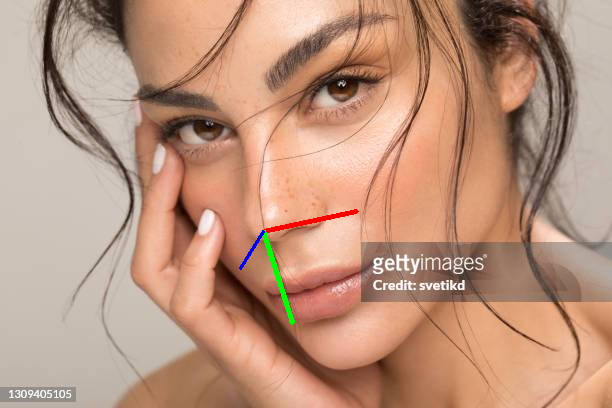

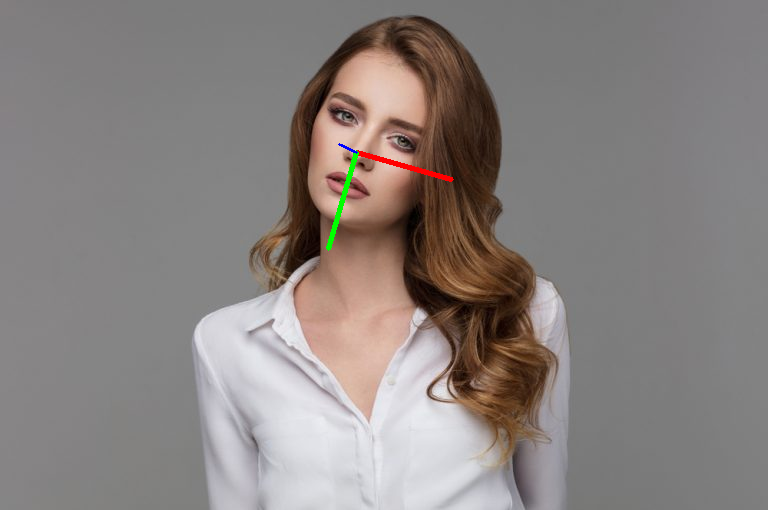

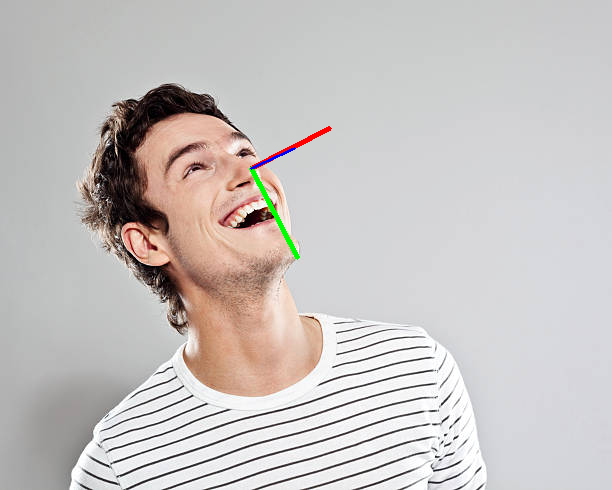

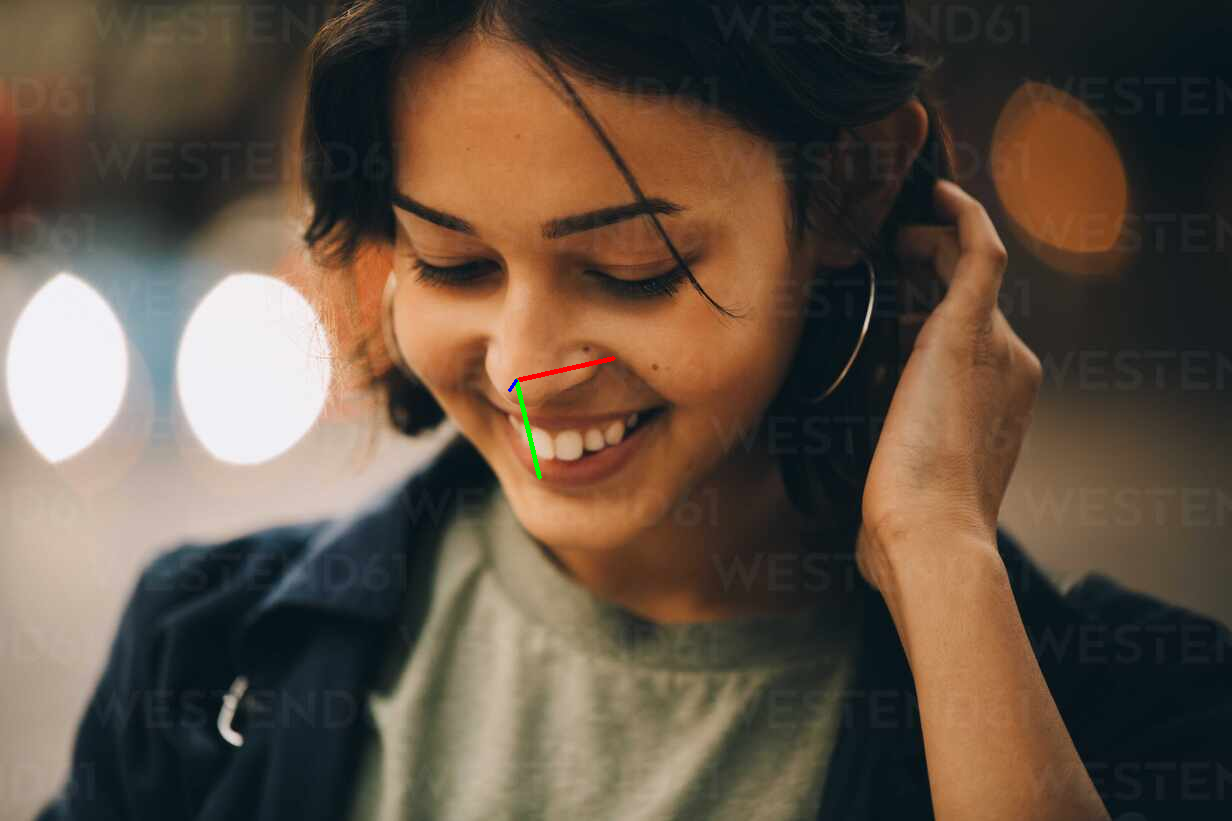

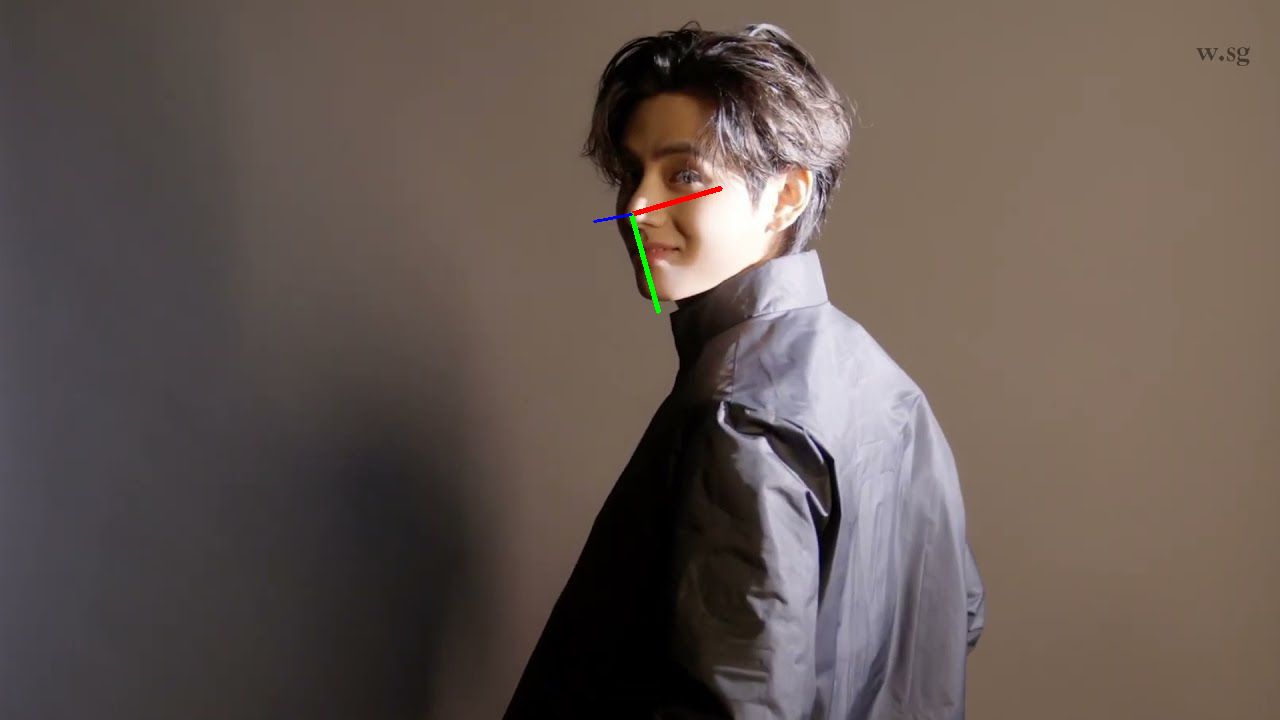

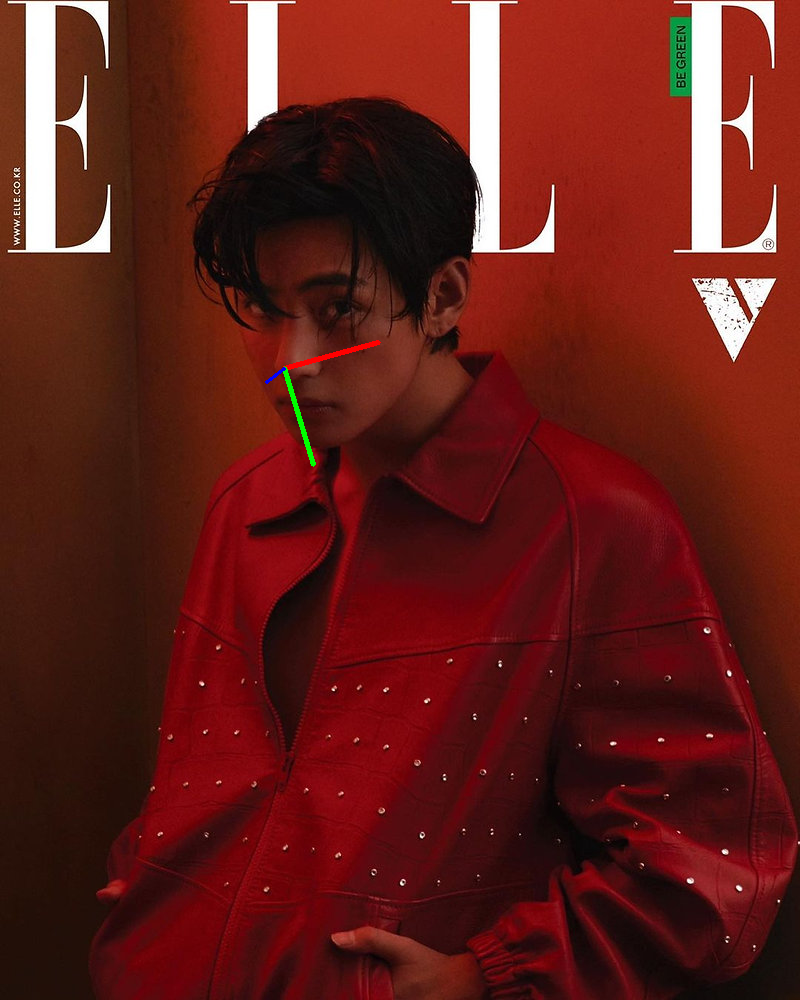

In [ ]:
for i in range(1, 7):
    img_path = f'/content/drive/MyDrive/test photos/test{i}.jpg'
    axes_prediction(img_path)

## testing the model on a video

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from math import cos, sin
from google.colab.patches import cv2_imshow

def axes_prediction(video_path, output_path):
    data = []
    faceModule = mp.solutions.face_mesh

    # Creating a FaceMesh instance
    with faceModule.FaceMesh(static_image_mode=False, max_num_faces=1) as faces:

        # Open the video
        cap = cv2.VideoCapture(video_path)

        # Get video properties
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Create VideoWriter for output
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Convert frame to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Process the face to extract the landmark points for x, y
            results = faces.process(rgb_frame)

            if results.multi_face_landmarks:
                for idx, lm in enumerate(results.multi_face_landmarks[0].landmark):
                    if idx == 4:
                        nose_x = lm.x
                        nose_y = lm.y

                    if idx == 291:
                        lower_x = lm.x
                        lower_y = lm.y

                    if idx == 33:
                        upper_x = lm.x
                        upper_y = lm.y

                # Calculate distance and normalize landmarks
                distance_x = upper_x - lower_x
                distance_y = upper_y - lower_y
                distance = np.sqrt(distance_x**2 + distance_y**2)

                # Extract normalized landmarks
                normalized_landmarks = []
                for face in results.multi_face_landmarks:
                    for landmark in face.landmark:
                        x = (landmark.x - nose_x) / distance
                        y = (landmark.y - nose_y) / distance
                        shape = frame.shape
                        x = int(x * shape[1])
                        y = int(y * shape[0])
                        normalized_landmarks.extend([x, y])

                # Predict using SVR models
                normalized_landmarks = np.array(normalized_landmarks).reshape(1, -1)
                pitch = svr_pitch.predict(normalized_landmarks)
                yaw = svr_yaw.predict(normalized_landmarks)
                roll = svr_roll.predict(normalized_landmarks)

                # Display the results on the frame
                center_point = (nose_x * width, nose_y * height)
                frame_with_axes = draw_axes(frame, pitch, yaw, roll, center_point)
                out.write(frame_with_axes)

        # Release video capture and writer
        cap.release()
        out.release()
        cv2.destroyAllWindows()

def draw_axes(img, pitch, yaw, roll, center_point, size=100):
    yaw = -yaw

    if center_point is None:
        height, width = img.shape[:2]
        center_point = (width / 2, height / 2)

    tdx, tdy = center_point

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    cv2.line(img, (int(tdx), int(tdy)), (int(x1), int(y1)), (0, 0, 255), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2), int(y2)), (0, 255, 0), 3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3), int(y3)), (255, 0, 0), 2)

    return img

In [ ]:
# Example usage
axes_prediction('/content/drive/MyDrive/Sample2', '/content/drive/MyDrive/result2.mp4')